### Compare the three different RAG approaches

1. using [byaldi package](https://github.com/AnswerDotAI/byaldi)
2. using [CLIP Model to compare query and slide embedding](https://huggingface.co/openai/clip-vit-base-patch32)

Both methods were first implemented in own notebooks. Here, the different approaches are compared for one single task:

Finding the best matching slides for the question: *"What are the different stages of a data life cycle?"*

In [47]:
import sys
import os

# Add parent directory to be able to import modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [6]:
import os
import pandas as pd
from natsort import natsorted
from caching import load_full_hf_cache, get_zenodo_pdfs
from pdf_utilities import download_all_pdfs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
import base64
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## 1. Using the [byaldi package](./RAG_with_byaldi.ipynb)
If you want to use this package, you have to install [Poppler](https://poppler.freedesktop.org/) first.

In [9]:
from byaldi import RAGMultiModalModel
docs_retrieval_model = RAGMultiModalModel.from_pretrained(pretrained_model_name_or_path = "vidore/colpali-v1.2", device = "cpu")

# configure the path
index_path = os.path.join(parent_dir, ".byaldi", "pdf_index")

docs_retrieval_model = RAGMultiModalModel.from_index(index_path, device='cpu')

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 2534 images from 6 JSON files.


In [11]:
text_query = "What are the different stages of a data life cycle?"

## a) Using the Top 4 best scoring Slides

In [12]:
k_results = 4
results = docs_retrieval_model.search(text_query, k=k_results)

In [1]:
reconstructed_images = []
scores = []

for result in results:
    base64_img = result["base64"]  
    image_data = base64.b64decode(base64_img)
    image = Image.open(BytesIO(image_data))
    reconstructed_images.append(image)
    scores.append(result["score"]) 

# Visualize
fig, axes = plt.subplots(1, len(reconstructed_images), figsize=(20, 8))

for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i])    
    ax.set_title(f"Similarity: {scores[i]:.3f}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

NameError: name 'results' is not defined

## b) Clustering the 20 best results into 3 Clusters, then choose the 2 clusters with the highest mean. From those, take the corresponding 2 best scoring slides.

In [17]:
k_results = 20
results = docs_retrieval_model.search(text_query, k=k_results)

# Prepare the data
scores = [item['score'] for item in results]
X = np.array(scores).reshape(-1, 1)

# Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

# Group results into clusters
clusters = {0: [], 1: [], 2: []}
for item, label in zip(results, labels):
    clusters[label].append(item)

# Sort each cluster by score (ascending)
for cluster in clusters.values():
    cluster.sort(key=lambda x: x['score'])

for cid, items in clusters.items():
    print(f"\nCluster {cid}:")
    for item in items:
        print(f"  doc_id: {item['doc_id']}, score: {item['score']}")

# Compute cluster means
cluster_means = {cid: np.mean([x['score'] for x in items]) for cid, items in clusters.items()}

# Get top 2 clusters by mean score
best_clusters = sorted(cluster_means, key=cluster_means.get, reverse=True)[:2]

# Take first 2 items from each of the best clusters
selected_results = []
for cid in best_clusters:
    selected_results.extend(clusters[cid][:2])


Cluster 0:
  doc_id: 68, score: 14.25
  doc_id: 2, score: 14.4375
  doc_id: 2, score: 14.625
  doc_id: 59, score: 14.625
  doc_id: 59, score: 14.75
  doc_id: 59, score: 14.8125
  doc_id: 2, score: 14.875
  doc_id: 39, score: 14.875
  doc_id: 2, score: 14.875
  doc_id: 59, score: 14.875
  doc_id: 2, score: 14.875
  doc_id: 59, score: 14.9375
  doc_id: 2, score: 15.375

Cluster 1:
  doc_id: 48, score: 12.625
  doc_id: 7, score: 12.875
  doc_id: 64, score: 12.9375
  doc_id: 14, score: 13.0
  doc_id: 48, score: 13.4375

Cluster 2:
  doc_id: 14, score: 16.875
  doc_id: 60, score: 17.375


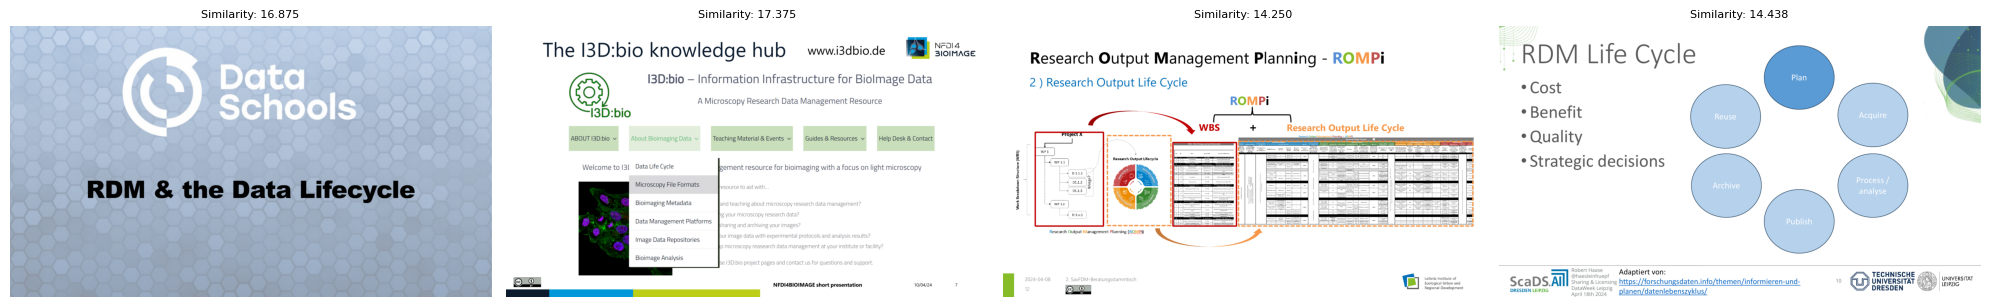

In [19]:
reconstructed_images = []
scores = []

for result in selected_results:
    base64_img = result["base64"]  
    image_data = base64.b64decode(base64_img)
    image = Image.open(BytesIO(image_data))
    reconstructed_images.append(image)
    scores.append(result["score"]) 

# Visualize
fig, axes = plt.subplots(1, len(reconstructed_images), figsize=(20, 8))

for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i])    
    ax.set_title(f"Similarity: {scores[i]:.3f}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

## 2. Using the [CLIP Model to compare query and slide embedding](./RAG_with_HF_Embeddings.ipynb)

In [20]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [21]:
# Tokenize the text 
inputs = clip_processor(text=[text_query], return_tensors="pt", padding=True)

# Get the text embedding from the model
with torch.no_grad():
    query_embedding = clip_model.get_text_features(**inputs)

# Normalize and send to the Device
query_vector = query_embedding / query_embedding.norm(dim=-1, keepdim=True) 
query_vector = query_vector.cpu().numpy()

In [22]:
from caching import load_full_hf_cache

repo_name = "ScaDS-AI/SlideInsight_Cache"
df = load_full_hf_cache(repo_name=repo_name)
df.head()

,key,zenodo_record_id,zenodo_filename,page_number,text_embedding,visual_embedding,mixed_embedding,extracted_text
0,record10008464_pdf1_slide1,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,1,"[0.8054575, -0.4204579, 0.111390926, 0.2636367...","[0.22024887800216675, 0.6564452648162842, 0.02...","[0.22330284, -0.5643485, 0.32713842, -0.074667...","Welcome to\nBioImage Town!\nJosh Moore, Senior..."
1,record10008464_pdf1_slide2,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,2,"[1.1522328, 0.02467385, 0.23145455, 0.17258961...","[-0.3846272826194763, -0.01668522134423256, -0...","[0.34757608, -0.6562839, 0.5335755, -0.1906935...",Special welcome\nHonored New\nGuests Colleague...
2,record10008464_pdf1_slide3,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,3,"[1.0057557, 0.18344171, 0.03796136, 0.23549518...","[-0.32376205921173096, 0.06897055357694626, 0....","[0.06456853, -0.79703176, 0.871621, -0.8768049...",Value of bioimages\nhttps://ome-model.readthed...
3,record10008464_pdf1_slide4,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,4,"[1.2563236, 0.25261688, 0.0040982994, 0.202414...","[-0.03493745997548103, -0.11242333054542542, 0...","[0.3643795, -0.40593308, 0.97395766, -0.495041...",Value of bioimages\nAll-Hands Meeting · Josh M...
4,record10008464_pdf1_slide5,10008464,2023-Moore-N4BI-AHM-Welcome.pdf,5,"[0.8471789, -0.40933934, 0.85754687, -0.496454...","[-0.6693567037582397, -0.02434205450117588, -0...","[-0.22939722, -0.6752343, 0.57570195, 0.046955...","Image Data Management isn’t always FAIR\n""Clar..."


In [23]:
# Extract the visual embeddings
visual_embeddings = df['visual_embedding'].apply(lambda x: np.array(x))
visual_matrix = np.stack(visual_embeddings.to_list()) 

In [25]:
# Compute similarity between the embedding matrix and the query vector
similarities = cosine_similarity(query_vector, visual_matrix) 
similarities = similarities.flatten()  

df['similarity_to_query'] = similarities

## a) Using the Top 4 best scoring Slides

In [26]:
# Get the 4 best matches
top_matches = df.sort_values(by='similarity_to_query', ascending=False).head(4)

# Extract the scores
X = top_matches['similarity_to_query'].values.reshape(-1, 1)

In [28]:
# Import Image dataset
from datasets import load_dataset, Image

dataset = load_dataset("ScaDS-AI/Slide_Insight_Images")["train"]  
dataset = dataset.cast_column("image", Image())
df_image = dataset.to_pandas()

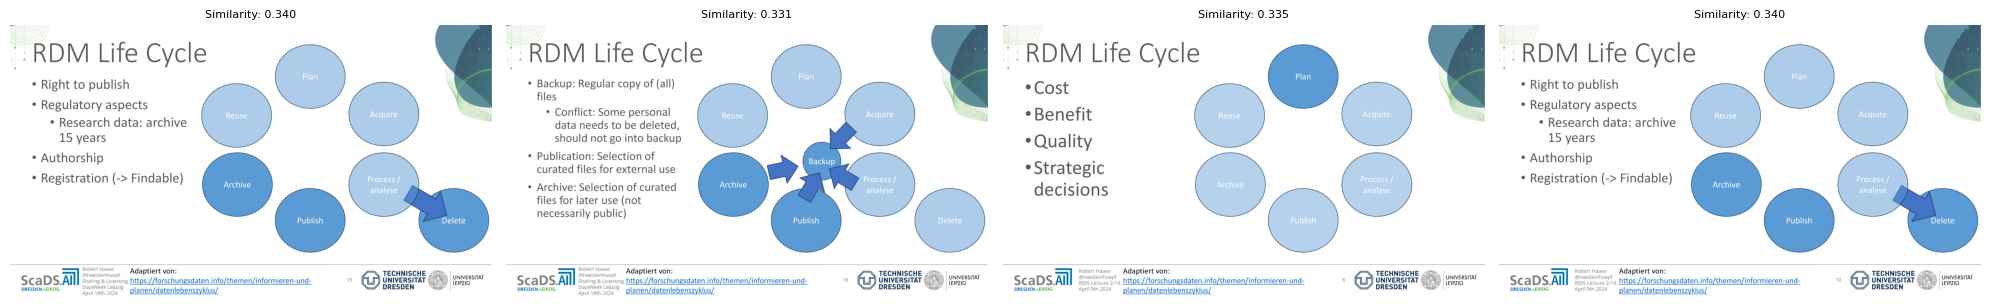

In [32]:
from PIL import Image

keys = top_matches['key'].tolist()
filtered_df = df_image[df_image["key"].isin(keys)]

# Plot the corresponding images
fig, axs = plt.subplots(1, 4, figsize=(20,8))

for i, (_, row) in enumerate(filtered_df.iloc[:5].iterrows()):
    img_bytes = row["image"]["bytes"]
    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    key = row["key"]

    # Look up the matching similarity score
    similarity_row = top_matches[top_matches["key"] == key]
    similarity_score = similarity_row.iloc[0]["similarity_to_query"]
        
    axs[i].imshow(img)
    axs[i].set_title(f"Similarity: {similarity_score:.3f}", fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## b) Clustering the 20 best results into 3 Clusters, then choose the 2 clusters with the highest mean. From those, take the corresponding 2 best scoring slides.

In [33]:
# Get the 20 best matches
top_matches = df.sort_values(by='similarity_to_query', ascending=False).head(20)

# Extract the scores
X = top_matches['similarity_to_query'].values.reshape(-1, 1)

In [34]:
# Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
top_matches['similarity_cluster'] = kmeans.fit_predict(X)

In [35]:
# Compute the means of the Clusters to extract the two best groups
cluster_means = (
    top_matches.groupby('similarity_cluster')['similarity_to_query']
    .mean()
    .sort_values(ascending=False)
)

top_clusters = cluster_means.index[:2]

In [36]:
# Extract top 2 rows from each top cluster (by similarity)
selected_rows = pd.concat([
    top_matches[top_matches['similarity_cluster'] == cluster].nlargest(2, 'similarity_to_query')
    for cluster in top_clusters
])

In [37]:
selected_rows

,key,zenodo_record_id,zenodo_filename,page_number,text_embedding,visual_embedding,mixed_embedding,extracted_text,similarity_to_query,similarity_cluster
427,record10990107_pdf1_slide15,10990107,DataWeek_Sharing+Licensing.pdf,15,"[-0.14453207, -0.0045383503, 0.24317652, 0.215...","[-0.49601292610168457, 0.2227572649717331, 0.1...","[-0.20711239, -0.42845377, 0.37009004, -0.4355...",RDM Life Cycle\nPlan\n• Right to publish\n• Re...,0.340207,2
1084,record12623730_pdf2_slide10,12623730,02_Introduction_RDM_2024.pdf,10,"[-0.23594418, -0.09563972, 0.27896404, 0.24454...","[-0.48465630412101746, 0.2094745635986328, 0.1...","[0.033804603, -0.1870009, 0.28877252, -0.45642...",RDM Life Cycle\nPlan\n• Right to publish\n• Re...,0.340016,2
428,record10990107_pdf1_slide16,10990107,DataWeek_Sharing+Licensing.pdf,16,"[-0.43196034, -0.11323718, 0.53981763, 0.40979...","[-0.47873860597610474, 0.4272165298461914, 0.1...","[0.06167328, -0.109886795, 0.32167792, -0.2011...",RDM Life Cycle\nPlan\n• Backup: Regular copy o...,0.331098,0
2269,record4778265_pdf1_slide8,4778265,intro_rdm_os_srds_short.pdf,8,"[-0.1796551, 0.23936217, 0.22878434, -0.211544...","[0.16421817243099213, 0.5350028276443481, -0.1...","[-0.2342556, -0.25038087, 0.3545423, 0.0667767...",RDM & the Data Lifecycle,0.330170,0


In [39]:
# Extract the keys
keys = selected_rows['key'].tolist()

# Filter the rows to obtain the Images with the highest similarity to the Query
filtered_df = df_image[df_image["key"].isin(keys)]
filtered_df

,key,image
405,record4778265_pdf1_slide8,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
1180,record10990107_pdf1_slide15,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
1181,record10990107_pdf1_slide16,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
1837,record12623730_pdf2_slide10,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...


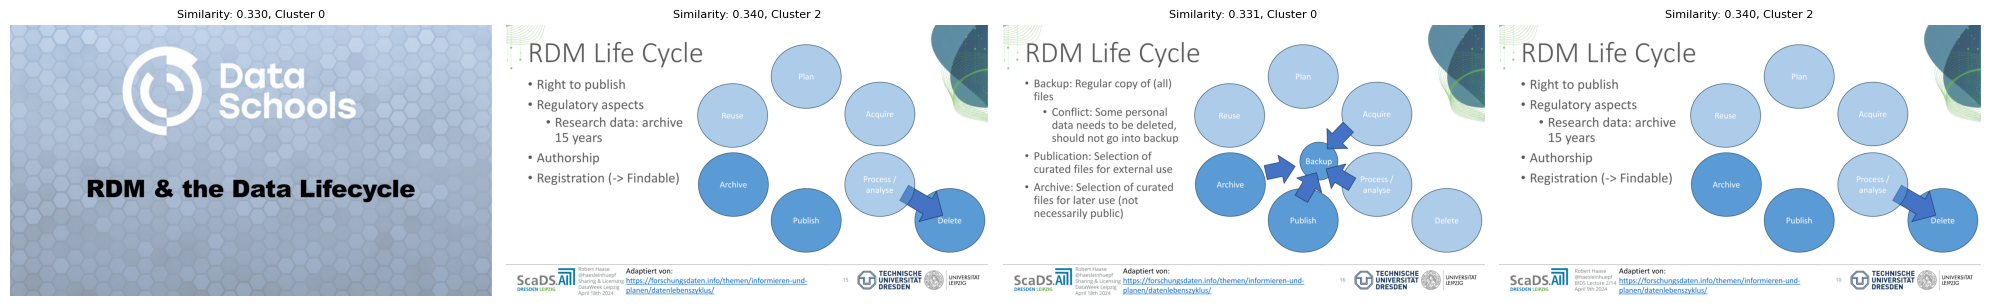

In [41]:
# Import PIL Image again, because it got overwritten from the datasets Image function in the cell above
from PIL import Image


fig, axs = plt.subplots(1, 4, figsize=(20,8))

for i, (_, row) in enumerate(filtered_df.iloc[:4].iterrows()):
    img_bytes = row["image"]["bytes"]
    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    key = row["key"]

    # Look up the matching similarity score
    similarity_row = top_matches[top_matches["key"] == key]
    similarity_score = similarity_row.iloc[0]["similarity_to_query"]
    similarity_cluster = similarity_row.iloc[0]["similarity_cluster"]
        
    axs[i].imshow(img)
    axs[i].set_title(f"Similarity: {similarity_score:.3f}, Cluster {similarity_cluster}", fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## First Intuition shows, that the second approach leads to better suitable slides.
Now the best scoring slides are further explored, using the second approach. 

In [42]:
# Now extract all 20 matches from the DataFrame, not only the Top 4

keys = top_matches['key'].tolist()
filtered_df = df_image[df_image["key"].isin(keys)]

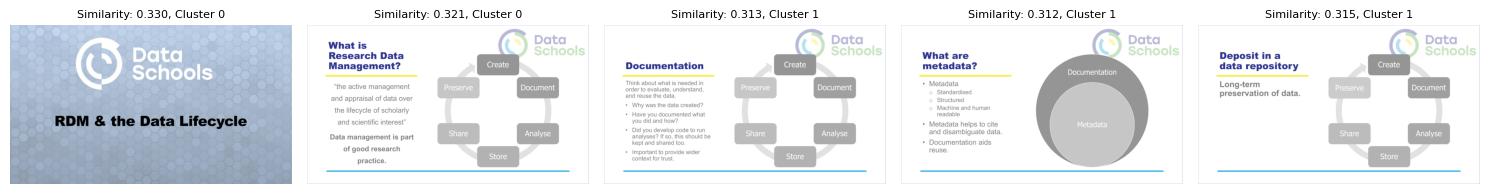

In [43]:
from PIL import Image


fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for i, (_, row) in enumerate(filtered_df.iloc[:5].iterrows()):
    img_bytes = row["image"]["bytes"]
    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    key = row["key"]

    # Look up the matching similarity score
    similarity_row = top_matches[top_matches["key"] == key]
    similarity_score = similarity_row.iloc[0]["similarity_to_query"]
    similarity_cluster = similarity_row.iloc[0]["similarity_cluster"]
        
    axs[i].imshow(img)
    axs[i].set_title(f"Similarity: {similarity_score:.3f}, Cluster {similarity_cluster}", fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

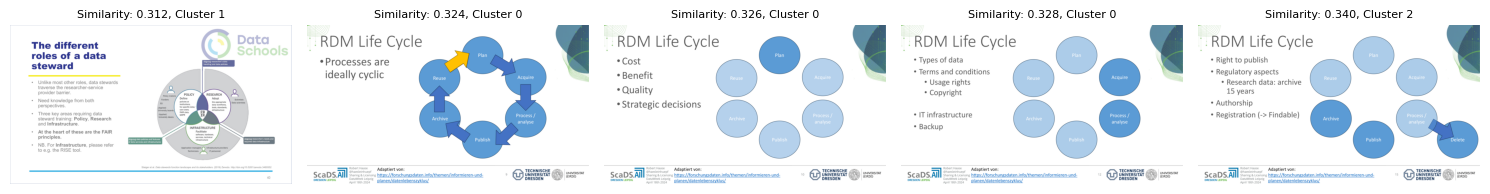

In [44]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for i, (_, row) in enumerate(filtered_df.iloc[5:10].iterrows()):
    img_bytes = row["image"]["bytes"]
    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    key = row["key"]

    # Look up the matching similarity score
    similarity_row = top_matches[top_matches["key"] == key]
    similarity_score = similarity_row.iloc[0]["similarity_to_query"]
    similarity_cluster = similarity_row.iloc[0]["similarity_cluster"]
        
    axs[i].imshow(img)
    axs[i].set_title(f"Similarity: {similarity_score:.3f}, Cluster {similarity_cluster}", fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

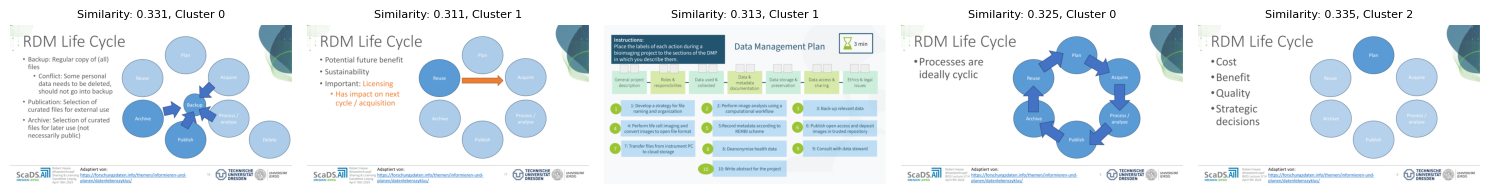

In [45]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for i, (_, row) in enumerate(filtered_df.iloc[10:15].iterrows()):
    img_bytes = row["image"]["bytes"]
    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    key = row["key"]

    # Look up the matching similarity score
    similarity_row = top_matches[top_matches["key"] == key]
    similarity_score = similarity_row.iloc[0]["similarity_to_query"]
    similarity_cluster = similarity_row.iloc[0]["similarity_cluster"]
        
    axs[i].imshow(img)
    axs[i].set_title(f"Similarity: {similarity_score:.3f}, Cluster {similarity_cluster}", fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

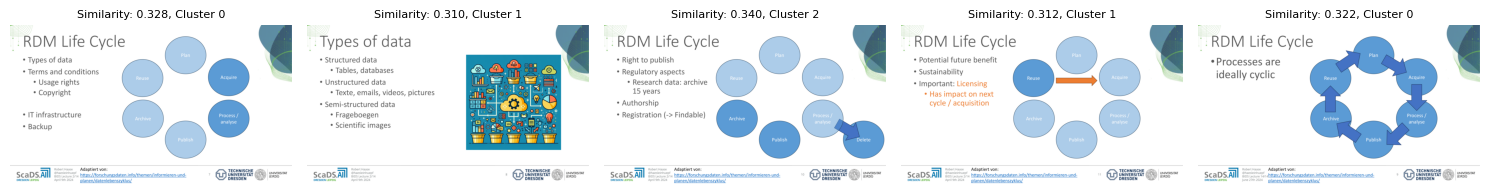

In [46]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for i, (_, row) in enumerate(filtered_df.iloc[15:20].iterrows()):
    img_bytes = row["image"]["bytes"]
    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    key = row["key"]

    # Look up the matching similarity score
    similarity_row = top_matches[top_matches["key"] == key]
    similarity_score = similarity_row.iloc[0]["similarity_to_query"]
    similarity_cluster = similarity_row.iloc[0]["similarity_cluster"]
        
    axs[i].imshow(img)
    axs[i].set_title(f"Similarity: {similarity_score:.3f}, Cluster {similarity_cluster}", fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()